## Zugriff auf Object-Storage von lokalem Rechner aus

In [2]:
import os
import oci
from oci.config import from_file
import io
from io import StringIO
import pandas as pd
from PIL import Image

In einer Config-Datei liegen alle Zugriffsinformationen auf den Object-Storage in der Cloud.
Diese wird einmalig eingelesen und steht innerhalb der Python-Umgebung als Dictionary-Struktur zur Verfügung.

In [3]:
config = from_file()
# Es wird folgende Datei auf dem lokalen Rechner gelesen :
#     C:\Users\ASCHLAUC\.oci\config
# Diese Datei wurde angelegt über einen Dialog in der Windows Power Shell oci setup config
# Danach muss der public PEM-Key in die Console geladen werden -> User Settings
#Folgender Fingerprint ist dort abgelegt: 76:36:3a:48:04:e2:a5:71:aa:ce:48:5c:a5:97:ef:9b


In [5]:
# Ausgabe der Konfigurationseinträge 
config

{'log_requests': False,
 'additional_user_agent': '',
 'pass_phrase': 'Aths',
 'user': 'ocid1.user.oc1..aaaaaaaarz3j2ei2nubmaymhcykqjh5sopjzkaq2idzqgxddfmqbbvd63yma',
 'fingerprint': '76:36:3a:48:04:e2:a5:71:aa:ce:48:5c:a5:97:ef:9b',
 'key_file': 'C:\\Users\\ASCHLAUC\\.oci\\oci_api_key.pem',
 'tenancy': 'ocid1.tenancy.oc1..aaaaaaaap7sg74i4ibhxz7ymmv343ztoyytoi3sp5bwj4r6ydz6fscx6nuka',
 'region': 'eu-frankfurt-1'}

In [6]:
# Auslesen der Config-Informationen
print("Der Typ des config-Objektes: ",type(config))
print("Die Keys des Dictionarys: ",config.keys())

Der Typ des config-Objektes:  <class 'dict'>
Die Keys des Dictionarys:  dict_keys(['log_requests', 'additional_user_agent', 'pass_phrase', 'user', 'fingerprint', 'key_file', 'tenancy', 'region'])


In [7]:
for k in config:
    print("Key: ",k, " ->","Value:  ",config[k])

Key:  log_requests  -> Value:   False
Key:  additional_user_agent  -> Value:   
Key:  pass_phrase  -> Value:   Aths
Key:  user  -> Value:   ocid1.user.oc1..aaaaaaaarz3j2ei2nubmaymhcykqjh5sopjzkaq2idzqgxddfmqbbvd63yma
Key:  fingerprint  -> Value:   76:36:3a:48:04:e2:a5:71:aa:ce:48:5c:a5:97:ef:9b
Key:  key_file  -> Value:   C:\Users\ASCHLAUC\.oci\oci_api_key.pem
Key:  tenancy  -> Value:   ocid1.tenancy.oc1..aaaaaaaap7sg74i4ibhxz7ymmv343ztoyytoi3sp5bwj4r6ydz6fscx6nuka
Key:  region  -> Value:   eu-frankfurt-1


In [8]:
# Testzwecke
from oci.config import validate_config
print(validate_config(config))

None


Auf den Object Storage zugreifen

In [9]:
# Namespace abgreifen 
compartment_id = config["tenancy"]
print("root-compartment_id:  ->",compartment_id)
object_storage = oci.object_storage.ObjectStorageClient(config)
print("object_storage: ->", object_storage)
namespace = object_storage.get_namespace().data
print("namespace: ->",namespace)



root-compartment_id:  -> ocid1.tenancy.oc1..aaaaaaaap7sg74i4ibhxz7ymmv343ztoyytoi3sp5bwj4r6ydz6fscx6nuka
object_storage: -> <oci.object_storage.object_storage_client.ObjectStorageClient object at 0x00000175D418BA20>
namespace: -> oraseemeadesandbox


In [10]:
bucket_name = "seminar"
bucket = object_storage.get_bucket(namespace, bucket_name)
type(bucket)


oci.response.Response

In [23]:
object_list = object_storage.list_objects(namespace, bucket_name)
for o in object_list.data.objects:
    print(o.name)

D_KUNDE.dsv
Einwanderung_Deutschland.csv
Katze.png
Kosten_PKW.csv
Mon_Temp.csv
boston_house_prices.csv
iris.csv
trousers_1.jpg
wisc_bc_data.csv


Objekt aus dem Object-Storage laden

In [24]:
#object_name = "bag01.jpg"
#object_name = "boston_house_prices.csv"
object_name = "D_KUNDE.dsv"
#destination_dir = '/home/oracle/tmp'.format(object_name) 
get_obj = object_storage.get_object(namespace, bucket_name, object_name)
for chunktest in get_obj.data.raw.stream(1024 * 1024, decode_content=False):
    chunktest

 Der Lesevorgang liefert zunächst nur Daten im Byte-Format

In [25]:
# Testausgabe
print(type(chunktest))
chunktest[0:200]

<class 'bytes'>


b'"","KUNDEN_NR","KD_GRUPPEN_NR","VORNAME","NACHNAME","ANREDE","LEBENSALTER","GESCHLECHT","STAND","WOHNART_NR","BILDUNGS_NR","GEHALT","BERUFSGRUPPEN_NR","EIGENTUM","ANZ_KINDER","BERUF_NR","KRITISCHER_KU'

In [26]:
#s=str(chunktest,'utf-8')  # Nur für boston_house_prices.csv
s=str(chunktest,'ISO-8859-1') # Nur für D_KUNDE

data = StringIO(s)
print(type(data))
contents = data.getvalue()
contents[0:200]

<class '_io.StringIO'>


'"","KUNDEN_NR","KD_GRUPPEN_NR","VORNAME","NACHNAME","ANREDE","LEBENSALTER","GESCHLECHT","STAND","WOHNART_NR","BILDUNGS_NR","GEHALT","BERUFSGRUPPEN_NR","EIGENTUM","ANZ_KINDER","BERUF_NR","KRITISCHER_KU'

Das wird erst handhabbar, wenn wir das Ganze in einen Pandas - Data Frame umwandeln

In [27]:
df=pd.read_csv(data)
df.head()

Unnamed: 0  KUNDEN_NR  KD_GRUPPEN_NR  VORNAME       NACHNAME ANREDE  \
0           1          1              1  Hiltrud           Pein   Frau   
1           2          2              1   Ortrud          Karlo   Frau   
2           3          3              1   Svenja  Fruechtenicht   Frau   
3           4          4              1     Olga           Bach   Frau   
4           5          5              1   Svenja   Messerschmid   Frau   

   LEBENSALTER  GESCHLECHT  STAND  WOHNART_NR  ...  BONITAET  KREDITFAEHIG  \
0           21           1      1           3  ...         4             0   
1           18           1      1           3  ...         3             0   
2           20           1      1           4  ...         3             0   
3           24           1      1           3  ...         3             0   
4           21           1      1           1  ...         3             0   

   SCHNAEPPCHENJAEGER  GEHOBENER_PREIS_KUNDE  NIEDRIG_PREIS_KUNDE  KUNDENTYP  \
0                   0                      0                    0          0   
1                   1                      0                    0          0   
2                   0                      0                    0          0   
3                   0                      0                    0          0   
4                   0                      0                    0          0   

   BERUFSKLASSE  ANZAHL_WERBUNG_MONAT  FREQUENZ_BESUCHE_MONAT   Gen_Datum  
0             1                     5                      11  2017-06-13  
1             1                     3                       7  2017-06-13  
2             1                     4                      11  2017-06-13  
3             1                     5                      11  2017-06-13  
4             1                     3                       8  2017-06-13  

[5 rows x 43 columns]

#### Bilder lesen

In [28]:
namespace = object_storage.get_namespace().data
bucket_name = "seminar"
#object_name = "trousers_1.jpg"
object_name = "Katze.png"
#object_name = "newtest.txt"
#destination_dir = '/home/oracle/tmp'.format(object_name) 
get_obj = object_storage.get_object(namespace, bucket_name, object_name)
for chunktest in get_obj.data.raw.stream(1024 * 1024, decode_content=False):
    chunktest

In [29]:
imageStream = io.BytesIO(chunktest)
imageFile = Image.open(imageStream)
print(type(imageFile))
print(imageFile.size)

<class 'PIL.PngImagePlugin.PngImageFile'>
(280, 184)


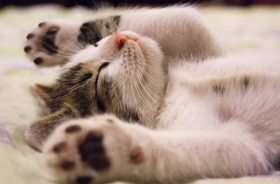

In [59]:
imageFile